<a href="https://colab.research.google.com/github/bilmark0/Deep-Learning-alpjai-Main-Project/blob/main/AI_model_vs_edge_detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Download dataset

In [ ]:
# Install kaggle library
!pip install kaggle==1.6.3 --force-reinstall

In [1]:
from google.colab import files
import zipfile
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
import cv2

# Ask the user to upload their kaggle.json file to download the data
uploaded = files.upload()

# Move the uploaded kaggle.json file to the proper directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Download the training data from kaggle
!kaggle competitions download -c airbus-ship-detection
!ls /content
# Unzip the file and delete the zip afterwards in order to save spaece
zip_file = '/content/airbus-ship-detection.zip'
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall()
os.remove(zip_file)
if os.path.exists('/content/sample_data'):
  shutil.rmtree('/content/sample_data')

print("Download and extraction complete.")


Saving kaggle.json to kaggle.json
100% 28.6G/28.6G [12:43<00:00, 40.8MB/s]
100% 28.6G/28.6G [12:43<00:00, 40.2MB/s]
airbus-ship-detection.zip  kaggle.json
Download and extraction complete.


###Data process

In [ ]:
# Set path to the .csv file containig the output rle-s
csv_path = '/content/train_ship_segmentations_v2.csv'

# Functio to count how many ships does each picture contains
def count_ships(csv_path):
    df = pd.read_csv(csv_path, header=None, skiprows=1)

    # Create a dictionary to count ships per filename
    ship_count = {}

    # Iterate through the DataFrame
    for index, row in df.iterrows():
        filename = row[0]  # Picture filename
        rle = row[1]  # RLE encoded map

        # Only process if the filename is a string and is not NaN
        if isinstance(filename, str) and filename.strip():
            if filename not in ship_count:
                ship_count[filename] = 0  # Initialize count for the filename

            # If RLE is not empty (and is a string), increment the ship count for this filename
            if isinstance(rle, str) and rle.strip():  # If there is an RLE code, it means there is at least one ship
                ship_count[filename] += 1

    # Count how many pictures have 0, 1, 2, etc. ships
    ship_distribution = {}
    for count in ship_count.values():
        if count not in ship_distribution:
            ship_distribution[count] = 0
        ship_distribution[count] += 1  # Count the occurrences of each ship count

    return ship_count, ship_distribution  # Return both dictionaries

# Function to find the picture with the maximum number of ships just for a funfact
def find_max_ships_picture(ship_count):
    max_ships = -1
    max_picture = None

    for filename, count in ship_count.items():
        if count > max_ships:
            max_ships = count
            max_picture = filename

    return max_picture, max_ships

# Count ships and plot the distribution
ship_count, ship_distribution = count_ships(csv_path)

max_picture, max_ships = find_max_ships_picture(ship_count)

# Load the .csv file, skipping the first row for safety
df = pd.read_csv('/content/train_ship_segmentations_v2.csv', skiprows=1, header=None, names=['filename', 'rle_data'])

# Convert RLE data to string, replacing NaN with an empty string
df['rle_data'] = df['rle_data'].astype(str).replace('nan', '')

# Group by filename and combine the RLE data, so that every picture only has one RLE output containing all the information
combined_df = df.groupby('filename')['rle_data'].apply(lambda x: ' '.join(x)).reset_index()

# Save the combined data to a new CSV file
combined_df.to_csv('combined_rle_data.csv', index=False)

csv_path = '/content/combined_rle_data.csv'
output_folder = '/content/rle_images'
os.makedirs(output_folder, exist_ok=True)

# Function to decode the rle codes for output data visualization
def rle_decode(rle, height, width):
    # Decodes the RLE encoded string into a binary mask (image) filled column by column.
    rle = list(map(int, rle.split()))
    img = np.zeros((height, width), dtype=np.uint8)  # Create an empty 2D array

    for start, length in zip(rle[::2], rle[1::2]):
        # Calculate column and row based on column-major order
        col_start = start // height  # Column index
        row_start = start % height    # Row index within that column

        for i in range(length):
            # Fill the pixel in column-major order
            img[(row_start + i) % height, col_start] = 255  # Update the corresponding pixel

    return img

# Creates the output images from the rle data
def process_rle_images(csv_path, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    with open(csv_path, 'r') as file:
        # Skip the first row (header)
        next(file)

        # Process each line in the CSV
        for line in file:
            # Strip whitespace and split by comma
            parts = line.strip().split(',')
            if len(parts) != 2:
                print(f"Skipping invalid line: {line.strip()}")
                continue  # Skip invalid lines

            filename, rle = parts
            filename = filename.strip()
            rle = rle.strip()

            # Decode the RLE into a 768x768 image
            img_data = rle_decode(rle, height=768, width=768)

            # Create an image from the array
            img = Image.fromarray(img_data, mode='L')  # 'L' mode for grayscale

            img.save(os.path.join(output_folder, filename))

# Process the images from RLE
process_rle_images(csv_path, output_folder)

# Set path to the .csv file containig the output rle-s
csv_path = '/content/train_ship_segmentations_v2.csv'

df = pd.read_csv(csv_path, header=None, skiprows=1)

# Initialize a dictionary to hold counts
ship_count = {}

# Iterate through each picture
for index, row in df.iterrows():
    filename = row[0]  # Picture filename
    rle = row[1]  # RLE encoded map

    # Only process if the filename is a string and is not NaN
    if isinstance(filename, str) and filename.strip():
        if filename not in ship_count:
            ship_count[filename] = {'count': 0, 'has_rle': False}

        # Count occurrences
        ship_count[filename]['count'] += 1

        # Check if there is an RLE code (indicating a ship is present)
        if isinstance(rle, str) and rle.strip():  # If there is an RLE code
            ship_count[filename]['has_rle'] = True

# Finalize the ship counts based on occurrences and presence of RLE
final_ship_count = {filename: (data['count'] if data['has_rle'] else 0) for filename, data in ship_count.items()}

dir1 = '/content/rle_images'
dir2 = '/content/train_v2'

#paring image names to ship counts

# List of files in both directories
files_dir1 = set(os.listdir(dir1))
files_dir2 = set(os.listdir(dir2))

# Find the common files between the two directories
common_files = files_dir1.intersection(files_dir2)

# Create a list to store the image pairs and counts
image_pairs = []
total_pairs_found = 0  # Initialize a counter for pairs found

# Create pairs of images with ship count
for file_name in common_files:
    count = final_ship_count.get(file_name, 0)  # Get the count, default to 0 if not found
    image_pairs.append((file_name, count))
    total_pairs_found += 1  # Increment the counter for each pair found

def separate_filenames_by_ship_count(image_pairs):
    # Initialize arrays for images with and without ships
    images_with_ships = []
    images_without_ships = []

    # Separate images based on ship count
    for filename, count in image_pairs:
        if count > 0:
            images_with_ships.append((filename, count))  # Append to images with ships
        else:
            images_without_ships.append((filename, count))  # Append to images without ships

    return images_with_ships, images_without_ships

# Call the function
with_ships, without_ships = separate_filenames_by_ship_count(image_pairs)

# Directories containing the images
dir_original = '/content/train_v2'  # Path to the original images
dir_rle = '/content/rle_images'       # Path to the RLE images

#Because we used different methods this was implemented
if isinstance(with_ships, np.ndarray):
    # Choose 5 random elements from the first column of the array
    selected_images = random.sample(list(with_ships[:, 0]), 5)  # Extract only the first column for filenames
else:
    # With_ships is a list containing filenames in the first position
    selected_images = random.sample([entry[0] for entry in with_ships], 5)

# Plot preparation:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, image_name in enumerate(selected_images):
    # Load the original and RLE images
    original_path = os.path.join(dir_original, f"{image_name}")
    rle_path = os.path.join(dir_rle, f"{image_name}")

    original_image = cv2.imread(original_path)
    rle_image = cv2.imread(rle_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

    # Check if images are loaded correctly
    if original_image is None:
        print(f"Error loading original image: {original_path}")
        continue
    if rle_image is None:
        print(f"Error loading RLE image: {rle_path}")
        continue

    # Create a binary mask
    binary_mask = (rle_image == 255).astype(np.uint8)  # 1 where white pixels, 0 where black pixels

    # Create an RGB mask with the desired color (magenta)
    color_mask = np.zeros_like(original_image, dtype=np.uint8)
    color_mask[binary_mask == 1] = [255, 0, 255]  # Assign magenta color to white regions

    # Apply the mask to the original image
    masked_image = cv2.addWeighted(original_image, 1, color_mask,1, 0)  # Blend the mask with the original image

    #Plot the masked image
    axes[i].imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    axes[i].set_title(image_name)
    axes[i].axis('off')

#plt.tight_layout()
#plt.show()

proportion = 0.7 #data% with ships
val_split = 0.01  # Proportion for validation
test_split = 0.0075  # Proportion for test

def merge_random_elements(with_ships, without_ships, proportion): #function to create the main traning dataset

    x = int(len(with_ships)/proportion*(1-proportion))
    # Shuffle the without_ships array
    random.shuffle(without_ships)

    # Take the first x elements from the shuffled without_ships array
    selected_without_ships = without_ships[:x]

    # Merge the selected elements with the with_ships array
    main_data = with_ships + selected_without_ships
    random.shuffle(main_data)

    return main_data

main_data = merge_random_elements(with_ships, without_ships, proportion) #when teaching the NN, these pictures will be used

val_size = int(len(main_data) * val_split)
test_size = int(len(main_data) * test_split)

val_data = main_data[:val_size]
test_data = main_data[val_size : val_size + test_size]
main_data = main_data[val_size + test_size:] #is also the traning data (has this name because it was used later and it would be a pain to rename elswhere)

# Sizes
print(f"Train size: {len(main_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")
print(f"Whith ships in train: {len([x for x in main_data if x[1] > 0])}")
print(f"Without ships in train: {len([x for x in main_data if x[1] == 0])}")

#Note that we won't be loading the pictures into arrays because it will take unnecessary memory space and
#converting the pictures into arrays does not take significant time when teaching the network (this may not be exactly true, but dou to size limitations in colabe we will do this to be safe)

###Modells

In [12]:
import os
import tensorflow as tf
import cv2
import numpy as np

# Load the saved model
model = tf.keras.models.load_model('mask_rcnn_best_model.keras')

# Directory containing the images
#image_directory = 'test_v2/'
image_directory = 'test_v1/'

# Specify the directory path
directory_path = '/content/edge_detected_images'

# Check if the directory exists
if os.path.exists(directory_path):
    # Iterate through all files in the directory
    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)
        try:
            # Check if it's a file and delete it
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)
            # If it's a folder, remove it recursively
            elif os.path.isdir(file_path):
                import shutil
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")
    print("All files and subfolders deleted successfully.")
else:
    print("The specified directory does not exist.")


# Directory to save the predicted masks
output_directory = 'predicted_masks/'

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Iterate through all files in the directory
for file_name in os.listdir(image_directory):
    # Construct the full file path
    image_path = os.path.join(image_directory, file_name)

    # Check if the file is an image (e.g., ends with .jpg, .png)
    if not file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    # Load and preprocess the input image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Unable to read image: {image_path}")
        continue

    # Resize the image to the input shape the model expects
    image_resized = cv2.resize(image, (384, 384))

    # Normalize the image
    image_resized = image_resized.astype(np.float32) / 255.0

    # Expand dimensions to add a batch axis
    image_input = np.expand_dims(image_resized, axis=0)

    # Make prediction
    predictions = model.predict(image_input)

    # Post-process predictions
    mask = predictions[0]
    mask = (mask > 0.5).astype(np.uint8)  # Convert to binary

    # Resize mask back to original image size for saving
    original_size_mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Construct output file path with "_pred" suffix
    output_file_name = f"{os.path.splitext(file_name)[0]}_pred.png"
    output_file_path = os.path.join(output_directory, output_file_name)

    # Save the predicted mask as an image
    cv2.imwrite(output_file_path, original_size_mask * 255)  # Scale mask back to 0-255 for saving as an image

print(f"Predicted masks saved in '{output_directory}'")


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted masks saved in 'predicted_masks/'


In [20]:
import os
import cv2
import numpy as np
# Directory containing the original images
#image_directory = 'test_v2/'
image_directory = 'test_v1/'

# Specify the directory path
directory_path = '/content/edge_detected_images'

# Check if the directory exists
if os.path.exists(directory_path):
    # Iterate through all files in the directory
    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)
        try:
            # Check if it's a file and delete it
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)
            # If it's a folder, remove it recursively
            elif os.path.isdir(file_path):
                import shutil
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")
    print("All files and subfolders deleted successfully.")
else:
    print("The specified directory does not exist.")

# Directory to save the edge-detected images
output_directory = 'edge_detected_images/'

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Iterate through all files in the directory
for file_name in os.listdir(image_directory):
    # Construct the full file path
    image_path = os.path.join(image_directory, file_name)

    # Check if the file is an image (e.g., ends with .jpg, .jpeg, .png)
    if not file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    # Load the original image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Unable to read image: {image_path}")
        continue

    # Convert the image to grayscale for edge detection
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection
    edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)

    # Create a mask of the edges by converting them to 3 channels
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    # Overlay the edges on the original image using bitwise AND
    masked_image = cv2.bitwise_and(image, edges_colored)

    # Construct output file path with "_edge" suffix
    output_file_name = f"{os.path.splitext(file_name)[0]}_edge.png"
    output_file_path = os.path.join(output_directory, output_file_name)

    # Save the masked image
    cv2.imwrite(output_file_path, masked_image)

print(f"Edge-detected images saved in '{output_directory}'")


All files and subfolders deleted successfully.
Edge-detected images saved in 'edge_detected_images/'


In [36]:
import os
import cv2
import numpy as np

# Specify the directory path
directory_path = '/content/refined_masks'

# Check if the directory exists
if os.path.exists(directory_path):
    # Iterate through all files in the directory
    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)
        try:
            # Check if it's a file and delete it
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)
            # If it's a folder, remove it recursively
            elif os.path.isdir(file_path):
                import shutil
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")
    print("All files and subfolders deleted successfully.")
else:
    print("The specified directory does not exist.")


# Directories containing the images
predicted_masks_directory = 'predicted_masks/'
edge_detected_images_directory = 'edge_detected_images/'
output_directory = 'refined_masks/'

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Get the list of predicted mask images
predicted_mask_images = [f for f in os.listdir(predicted_masks_directory) if f.lower().endswith('.png')]

# Iterate through all predicted mask images
for file_name in predicted_mask_images:
    # Construct file paths for the predicted mask and edge-detected image
    predicted_mask_path = os.path.join(predicted_masks_directory, file_name)
    edge_detected_path = os.path.join(edge_detected_images_directory, file_name.replace('_pred', '_edge'))

    # Check if the corresponding edge-detected image exists
    if not os.path.exists(edge_detected_path):
        print(f"Edge-detected image not found for: {file_name}")
        continue

    # Load the images
    predicted_mask = cv2.imread(predicted_mask_path, cv2.IMREAD_GRAYSCALE)
    edge_detected_image = cv2.imread(edge_detected_path, cv2.IMREAD_GRAYSCALE)

    # Ensure both images have the same dimensions
    if predicted_mask.shape != edge_detected_image.shape:
        print(f"Image size mismatch for: {file_name}")
        continue

    # Fill enclosed regions in the edge-detected image
    filled_edges = np.zeros_like(edge_detected_image)
    contours, _ = cv2.findContours(edge_detected_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(filled_edges, contours, -1, 255, thickness=cv2.FILLED)

    # Combine filled edges with the predicted mask to keep only valid areas
    refined_mask = cv2.bitwise_and(predicted_mask, filled_edges)

    # Construct output file path with "_refined" suffix (fixing naming issue)
    base_name = file_name.replace('_pred', '')  # Remove '_pred' from original name
    output_file_name = f"{os.path.splitext(base_name)[0]}_refined.png"
    output_file_path = os.path.join(output_directory, output_file_name)

    # Save the refined mask as an image
    cv2.imwrite(output_file_path, refined_mask)

print(f"Refined masks saved in '{output_directory}'")



All files and subfolders deleted successfully.
Refined masks saved in 'refined_masks/'


###Plot everything from a folder

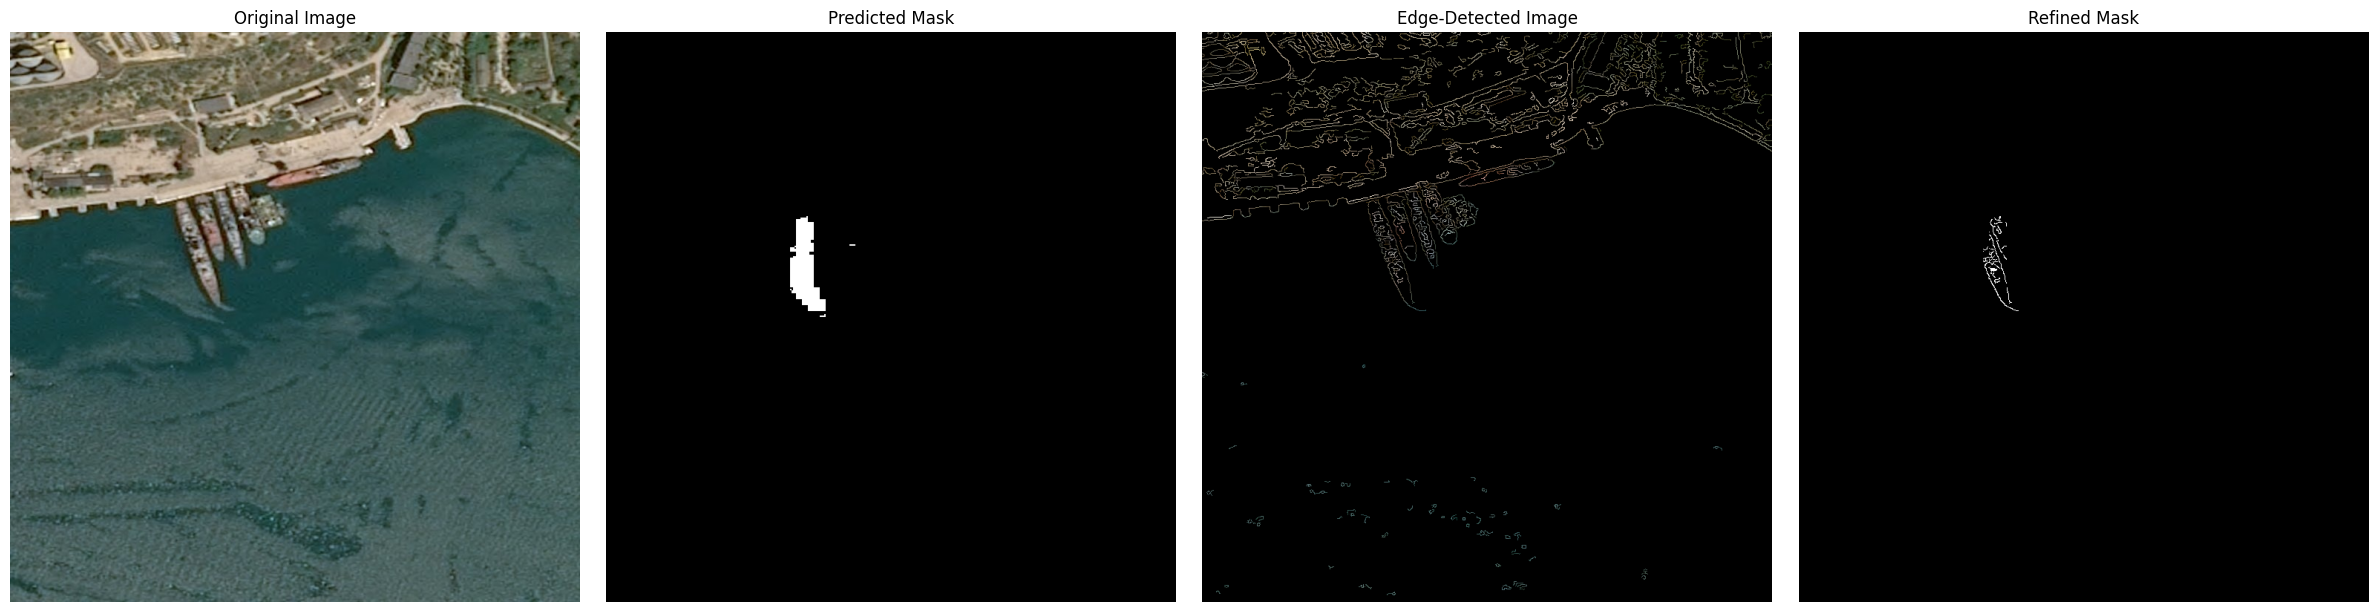

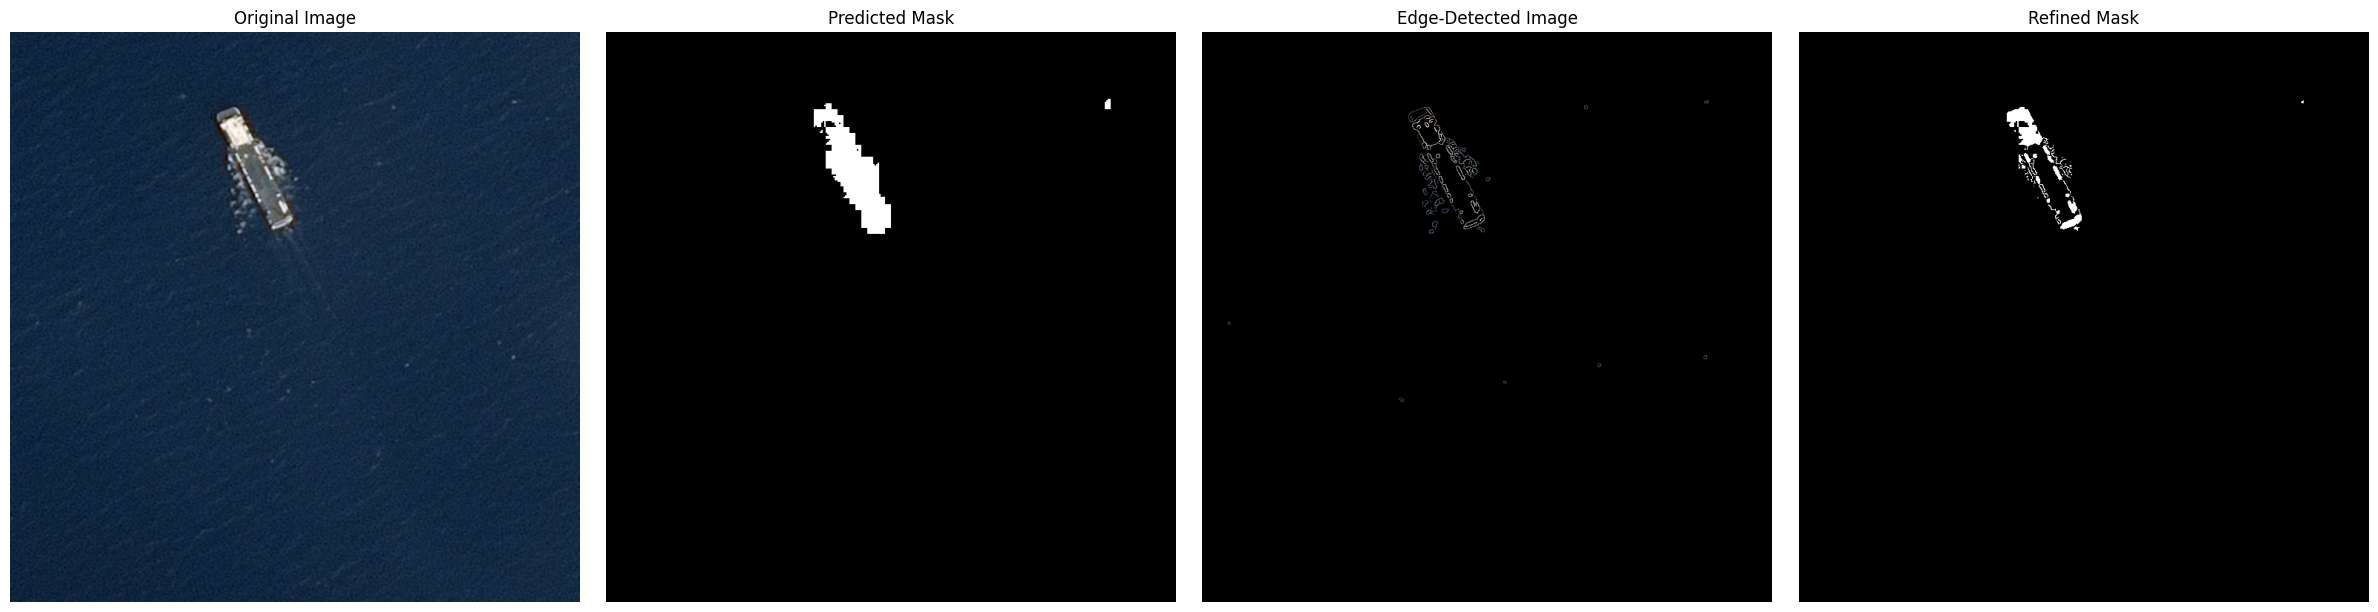

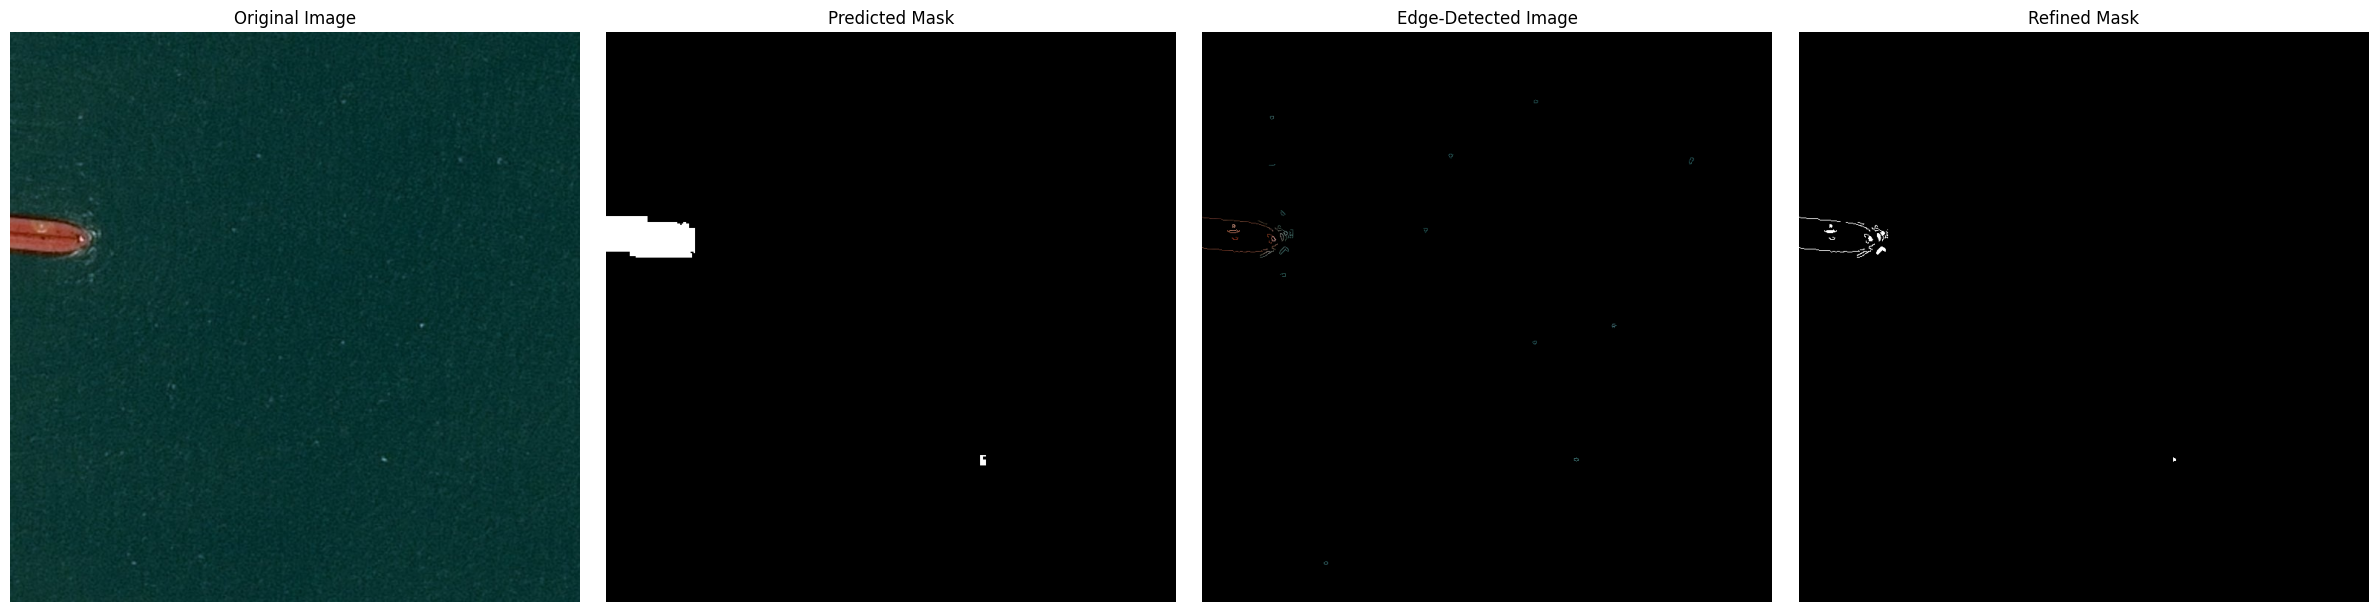

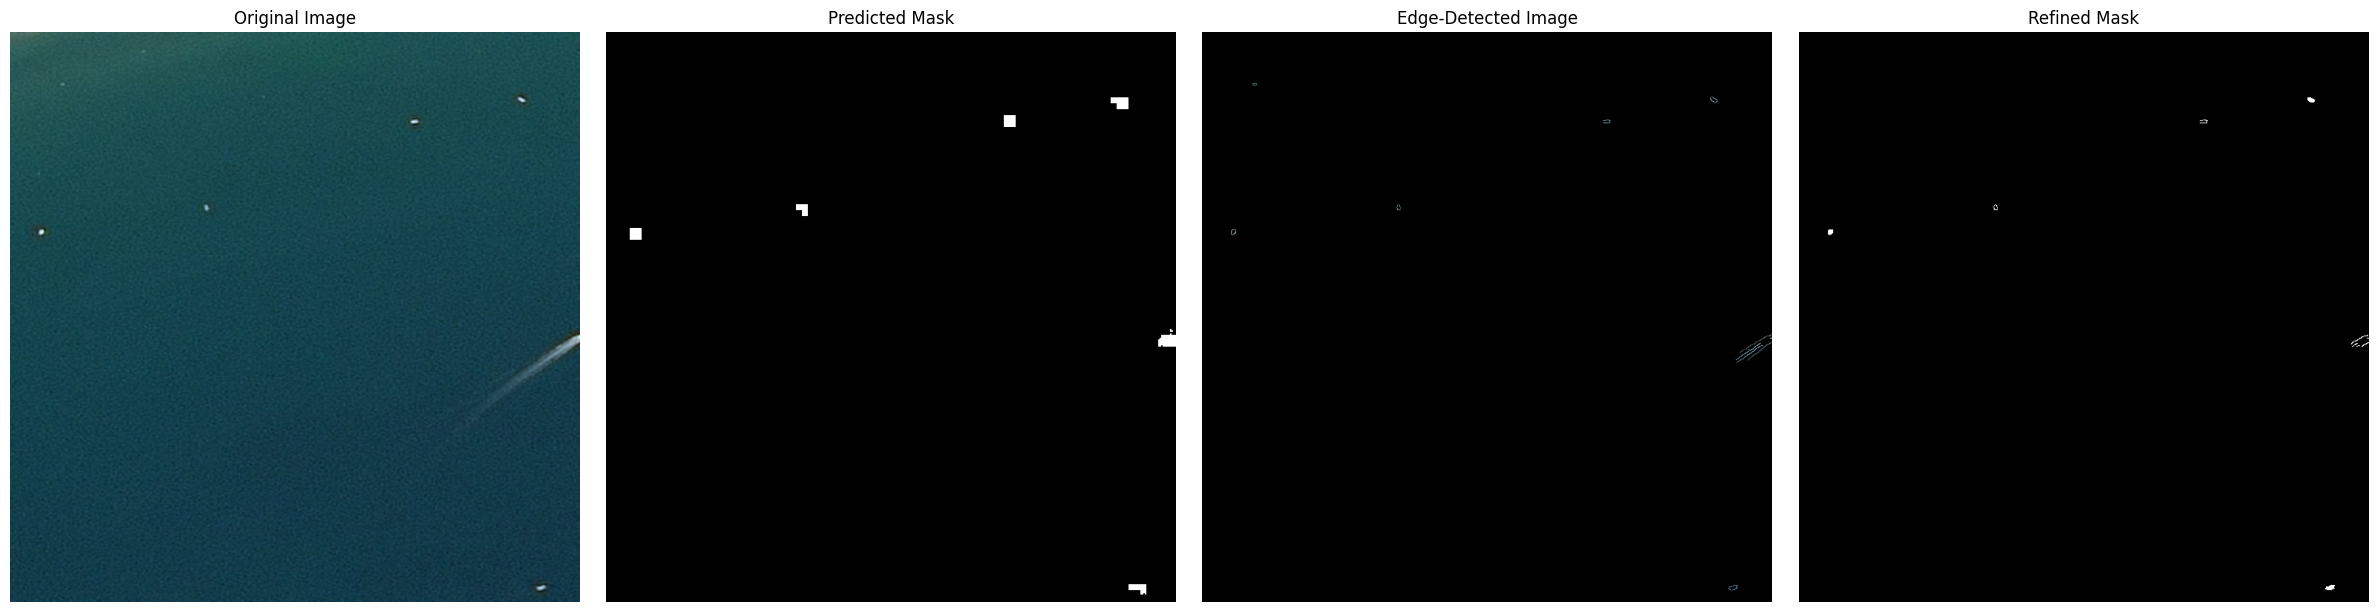

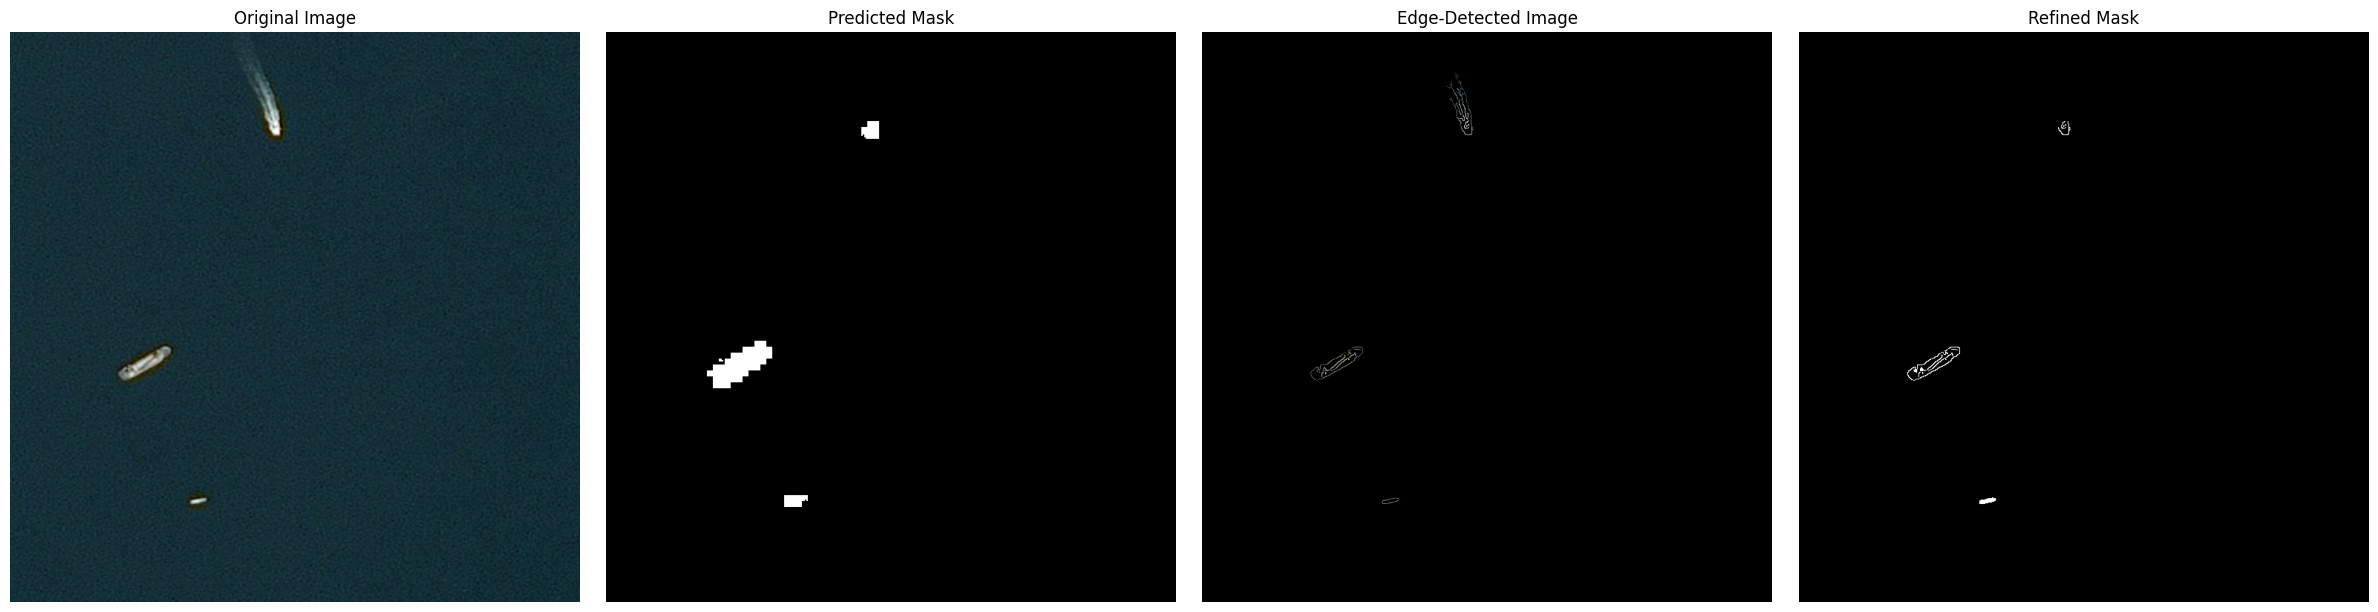

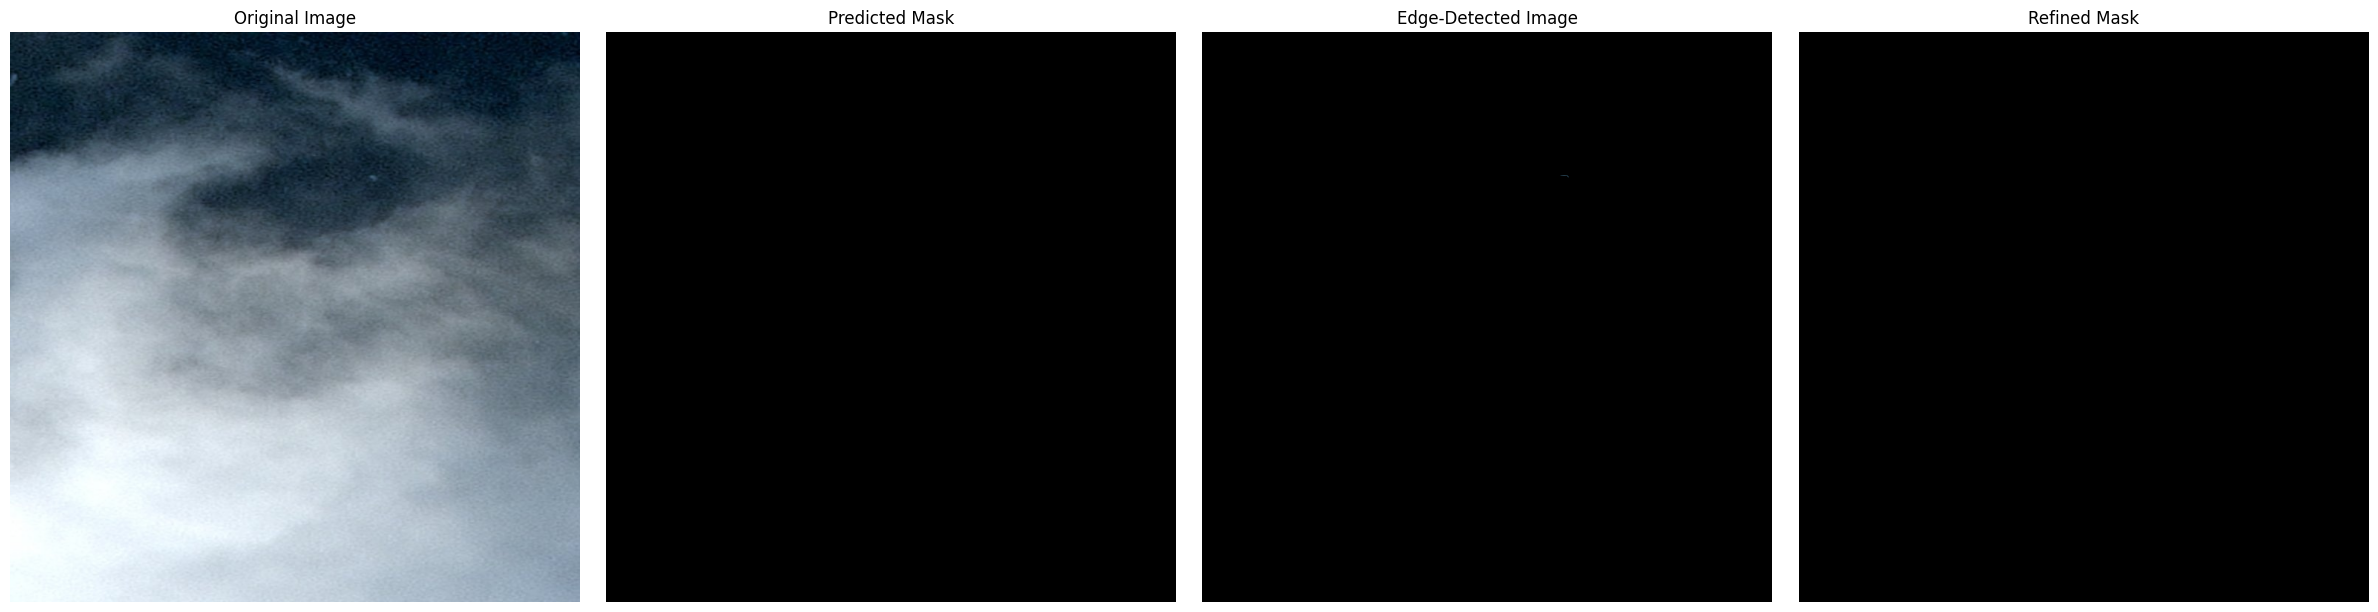

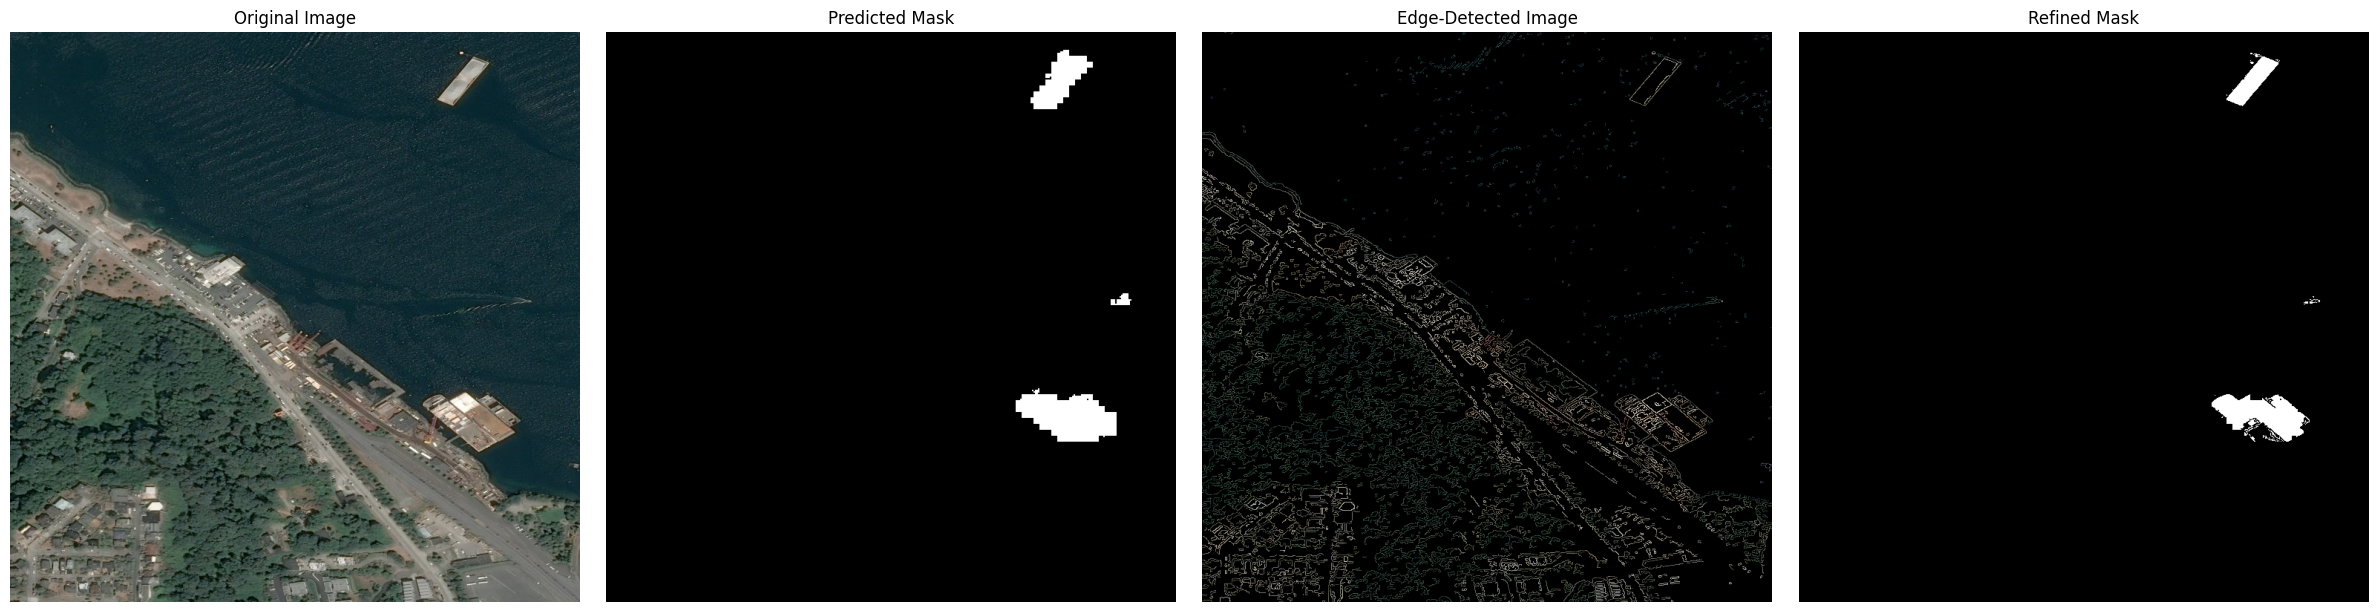

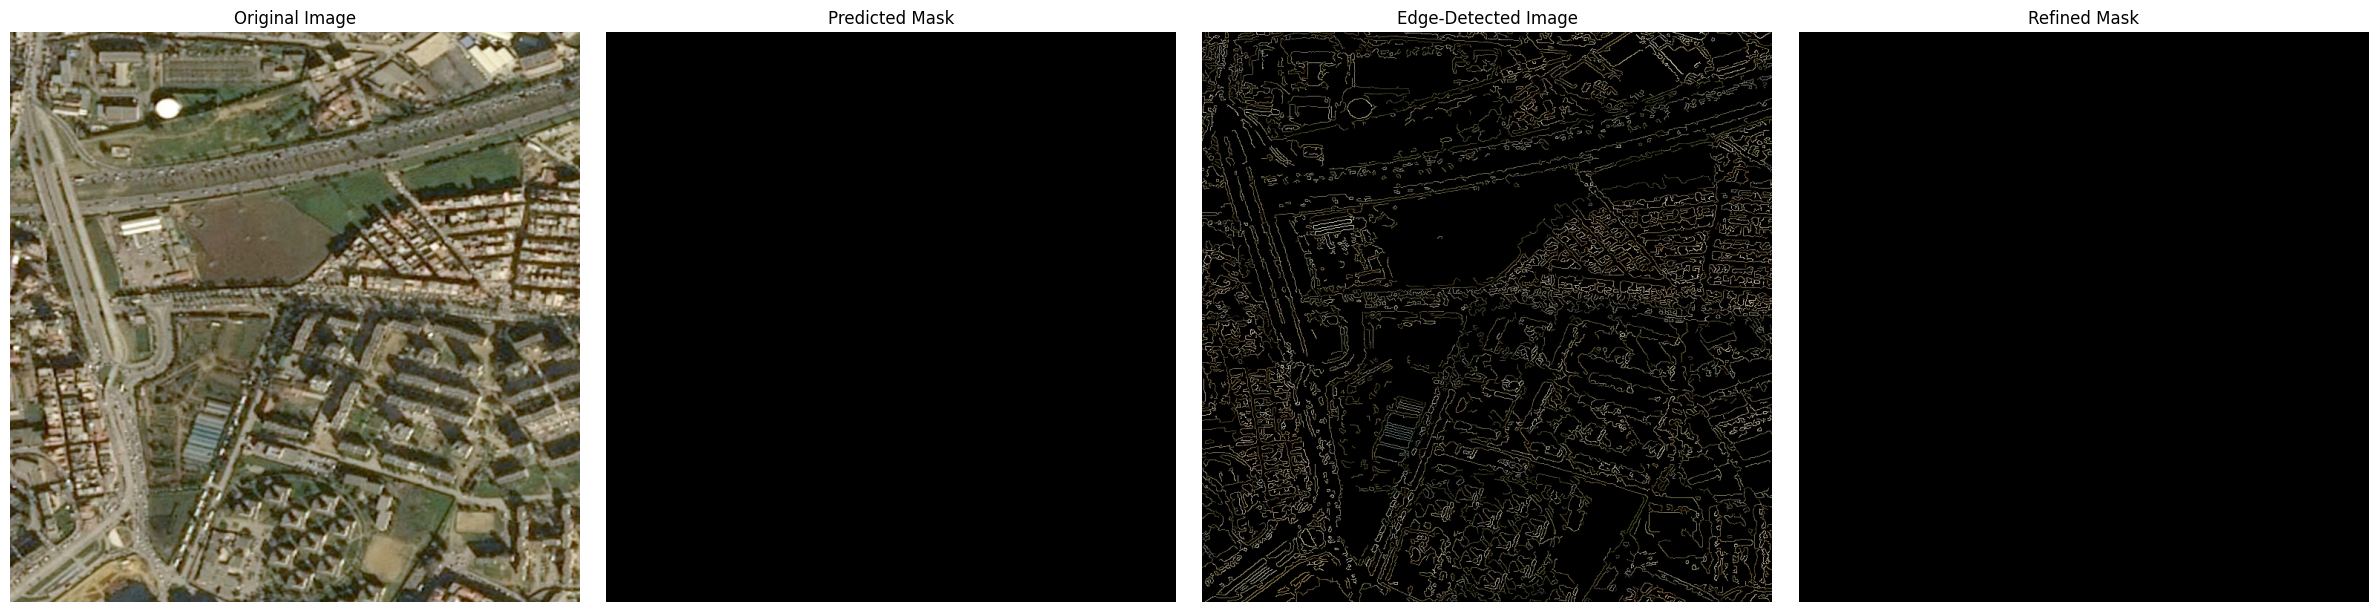

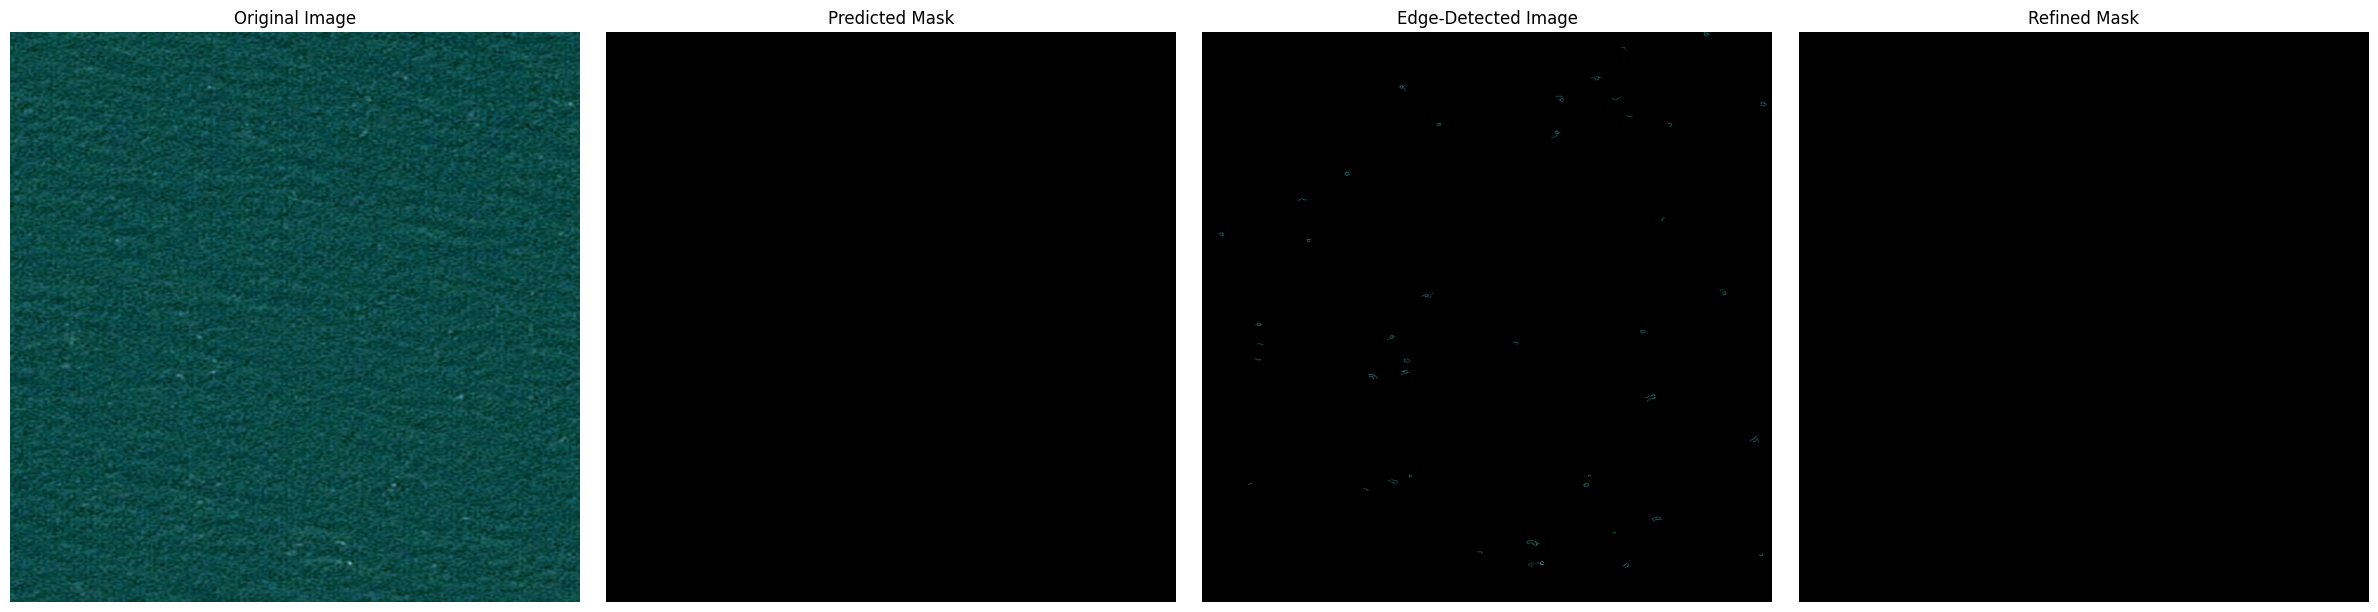

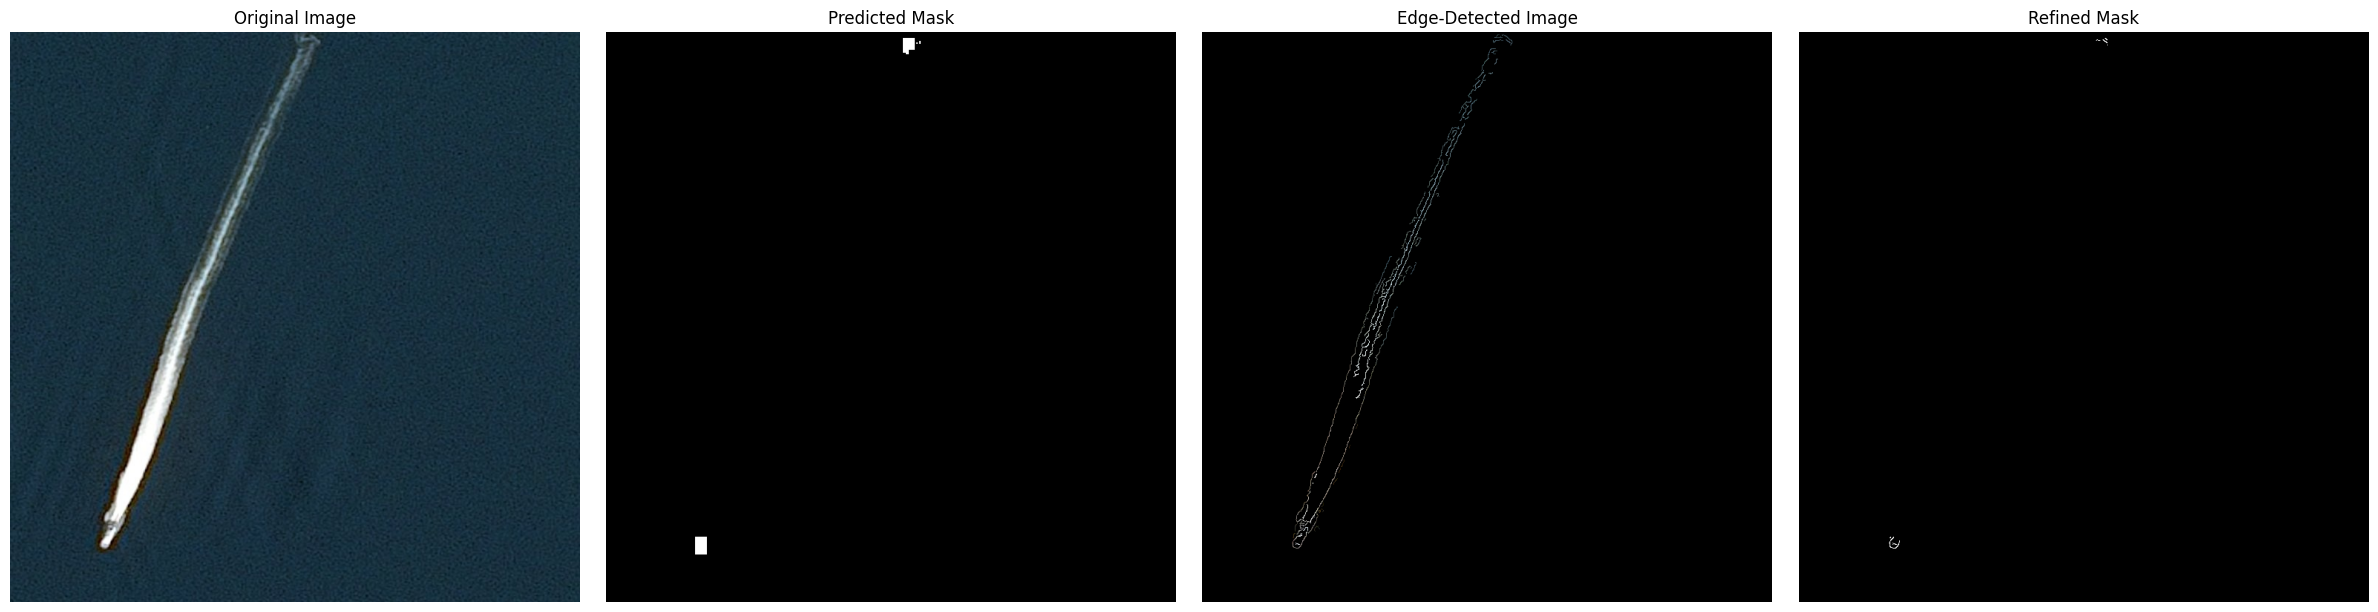

In [37]:
import os
import cv2
import matplotlib.pyplot as plt

# Directories containing the images
image_directory = 'test_v1/'  # Original images
predicted_masks_directory = 'predicted_masks/'  # Predicted masks
edge_detected_images_directory = 'edge_detected_images/'  # Edge-detected images
refined_masks_directory = 'refined_masks/'  # Refined masks

# Get the list of original images
original_images = [f for f in os.listdir(image_directory) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Iterate through all original images
for file_name in original_images:
    # Construct file paths for the original image, predicted mask, edge-detected image, and refined mask
    original_image_path = os.path.join(image_directory, file_name)
    predicted_mask_path = os.path.join(predicted_masks_directory, f"{os.path.splitext(file_name)[0]}_pred.png")
    edge_detected_path = os.path.join(edge_detected_images_directory, f"{os.path.splitext(file_name)[0]}_edge.png")
    refined_mask_path = os.path.join(refined_masks_directory, f"{os.path.splitext(file_name)[0]}_refined.png")

    # Check if the corresponding predicted mask, edge-detected image, and refined mask exist
    if not os.path.exists(predicted_mask_path):
        print(f"Predicted mask not found for: {file_name}")
        continue
    if not os.path.exists(edge_detected_path):
        print(f"Edge-detected image not found for: {file_name}")
        continue
    if not os.path.exists(refined_mask_path):
        print(f"Refined mask not found for: {file_name}")
        continue

    # Load the images
    original_image = cv2.imread(original_image_path)
    predicted_mask = cv2.imread(predicted_mask_path, cv2.IMREAD_GRAYSCALE)
    edge_detected_image = cv2.imread(edge_detected_path)
    refined_mask = cv2.imread(refined_mask_path, cv2.IMREAD_GRAYSCALE)

    # Plot the images side by side
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))

    # Original image
    axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Predicted mask
    axes[1].imshow(predicted_mask, cmap='gray')
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')

    # Edge-detected image
    axes[2].imshow(cv2.cvtColor(edge_detected_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
    axes[2].set_title("Edge-Detected Image")
    axes[2].axis('off')

    # Refined mask
    axes[3].imshow(refined_mask, cmap='gray')
    axes[3].set_title("Refined Mask")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()
